# From Pandas to Distributed Computing

## Dataset Characteristics

**Level 1 (lv1) - Raw Measurements**:
- **Time series data**: High-frequency voltage measurements with nanosecond timestamps
- **Multi-channel acquisition**: Parallel data streams from multiple measurement channels
- **Segmented structure**: Data organized by experimental runs, traces, and segments
- **High data density**: Continuous sampling creating large file sizes

**Level 2 (lv2) - Processed Features**:
- **Feature extraction**: Peak detection, rise times, pulse characteristics
- **Statistical summaries**: Aggregated measurements from raw data analysis
- **Quality metrics**: Data validation and measurement confidence indicators
- **Reduced dimensionality**: Processed features with much smaller memory footprint

In [1]:
from pathlib import Path
import dask.array as da
import dask.dataframe as dd
import psutil
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 934.07 GB


### Data Location Strategy

**Network Path Structure**: `/net/pr2/projects/tutorial/2025-09-25-hpda/dataset/`

### Performance Considerations for Network Data

**I/O Performance Factors**:
1. **Network latency**: Each file access requires network round-trip time
2. **Bandwidth limitations**: Network speed may be slower than local disk
3. **Concurrent access**: Multiple users accessing same data can create bottlenecks
4. **Caching effects**: Frequently accessed files may be cached closer to compute nodes

**Optimization Strategies**:
- **Bulk operations**: Read large chunks rather than many small files
- **Predicate pushdown**: Filter data at source to minimize data transfer
- **Local caching**: Copy frequently used datasets to local storage
- **Parallel I/O**: Distribute file access across multiple workers

In [3]:
lv1_path = Path('/net/pr2/projects/tutorial/2025-09-25-hpda/dataset/lv1/')
lv2_path = Path('/net/pr2/projects/tutorial/2025-09-25-hpda/dataset/lv2/')
lv1_path.exists(), lv2_path.exists()

(True, True)

# Pandas Approach: Traditional Single-File Processing

### Parquet Format Advantages for Scientific Data

**Why Parquet for Scientific Computing**:

1. **Columnar storage**: Excellent compression and query performance for analytical workloads
2. **Schema preservation**: Data types, column names automatically maintained
3. **Predicate pushdown**: Filters applied during file reading, not after loading
4. **Cross-platform compatibility**: Works seamlessly across Python, R, Spark, and other tools
5. **Metadata storage**: Supports column-level and file-level metadata essential for scientific data

### Advanced Filtering Strategy

The `filters` parameter demonstrates **predicate pushdown optimization**:

```python
filters=[
    ("dataset", "==", "1nA"),      # Measurement campaign selection
    ("channel_no", "==", 0),       # Single measurement channel
    ("trc_file_no", "==", 0),      # Specific trace file
    ("segment_no", "==", 0),       # Data segment selection
]
```

**Performance Benefits**:
- **I/O reduction**: Only matching rows read from storage
- **Memory efficiency**: Filtered dataset much smaller than full file
- **Network optimization**: Less data transferred over network connections
- **Processing speed**: Downstream operations work with smaller, focused datasets

In [ ]:
single_segment_df = pd.read_parquet(lv1_path, filters=[
    ("dataset", "==", "1nA"),
    ("channel_no", "==", 0),
    ("trc_file_no", "==", 0),
    ("segment_no", "==", 0),
])
single_segment_df.head()

### Raw Scientific Data Structure Analysis

**Examining the experimental data structure**:

The loaded DataFrame contains **time-series measurement data** with key characteristics:
- **time_ns**: Nanosecond-precision timestamps (essential for high-frequency measurements)
- **voltage_mV**: Millivolt-precision voltage readings (typical for scientific instrumentation)
- **trigger_time_ns**: Synchronization timestamps for event correlation
- **Hierarchical indexing**: Multi-level structure preserving experimental organization

### Memory Footprint Analysis

**Understanding dataset memory requirements**:

The `memory_usage(deep=True)` calculation provides **accurate memory consumption** including:
- **String data**: Variable-length strings with actual memory usage (not just pointer sizes)
- **DataFrame overhead**: Index structures, metadata, and pandas internal structures  
- **Compression effects**: Memory usage after decompression from parquet format
- **Data type efficiency**: Impact of chosen data types on memory consumption

In [ ]:
single_segment_df.memory_usage(deep=True).sum() / (1024 ** 3)

### Time Series Visualization for Scientific Data

**Data Reduction Strategy for Visualization**:

The `groupby(single_segment_df.index // 40)` technique demonstrates **intelligent data decimation**:

**Decimation Algorithm**:
1. **Grouping**: Every 40 consecutive measurements grouped together
2. **Averaging**: Time and voltage values averaged within each group
3. **Preservation**: Maintains overall signal shape and timing relationships
4. **Efficiency**: Dramatically reduces plot complexity while preserving scientific conten

In [ ]:
single_segment_df.groupby(single_segment_df.index // 40).agg({'time_ns': 'mean', 'voltage_mV': 'mean'}).plot(x='time_ns', y='voltage_mV', kind='scatter', figsize=(10, 5), s=1)

### Statistical Distribution Analysis

**Voltage Distribution Characteristics**:

The histogram reveals **fundamental measurement properties**:

**Scientific Interpretation**:
- **Baseline noise**: Distribution center indicates instrument noise floor
- **Dynamic range**: Histogram spread shows measurement sensitivity range  
- **Outlier detection**: Extreme values may indicate signal events or measurement artifacts

In [ ]:
single_segment_df.voltage_mV.hist(bins=100)

### Level 2 Data: Processed Feature Analysis

Level 2 data represents **processed measurements**:

**Feature Extraction Pipeline**:
- **Peak detection**: Automated identification of signal events in raw voltage data
- **Temporal analysis**: Rise times, pulse widths, decay characteristics
- **Amplitude measurements**: Peak heights, baseline corrections, signal-to-noise ratios
- **Quality metrics**: Confidence scores, fit parameters, detection reliability

In [3]:
df = pd.read_parquet(lv2_path, filters=[
    ("dataset", "==", "1nA"),
    ("channel_no", "==", 0),
    ("trc_file_no", "==", 0),
    ("segment_no", "==", 0),
])
df.head()

NameError: name 'lv2_path' is not defined

### Physics Feature Analysis: Pulse Rise Time Distribution

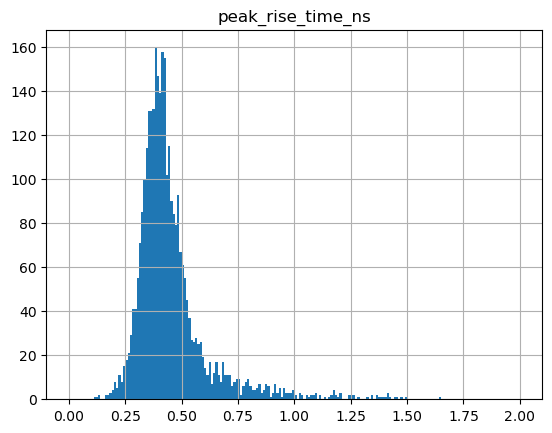

In [6]:
df.query('peak_length_ns > 1').hist('peak_rise_time_ns', bins=200, range=(0, 2));

# Dask Approach: 

### Distributed Computing Infrastructure Setup

The `Client()` initialization creates a **local distributed computing cluster**:

**Infrastructure Components**:
- **Scheduler**: Central coordinator managing task distribution and worker communication
- **Workers**: Separate Python processes (typically one per CPU core) executing computations  
- **Communication layer**: High-performance networking between scheduler and workers
- **Memory management**: Distributed memory pools across worker processes
- **Task queues**: Efficient work distribution and completion tracking

**Resource Allocation**:
- **Automatic configuration**: Dask automatically detects and utilizes available CPU cores
- **Memory per worker**: RAM distributed across workers based on system resources
- **Thread management**: Each worker manages multiple threads for I/O overlap
- **Network optimization**: Local networking optimized for minimal communication overhead

**Monitoring and Debugging**:
- **Dashboard access**: Real-time monitoring at http://localhost:8787 (default)
- **Performance profiling**: CPU usage, memory consumption, task execution timing
- **Visual task graphs**: Interactive visualization of computation pipelines
- **Resource utilization**: Monitor worker efficiency and identify bottlenecks

In [5]:
from dask.distributed import Client
client = Client()
client

/net/software/v1/software/dask/2025.5.1-gfbf-2025a/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36623 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36623/status,
Dashboard: http://127.0.0.1:36623/status,Workers: 4
Total threads: 4,Total memory: 31.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33987,Workers: 0
Dashboard: http://127.0.0.1:36623/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36351,Total threads: 1
Dashboard: http://127.0.0.1:39715/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:38057,


In [4]:
client.close()

### Distributed Data Loading with Predicate Pushdown

**Dask DataFrame Creation Strategy**:

The `dd.read_parquet()` operation creates a **lazy distributed DataFrame**:

**Key Differences from Pandas**:
- **Lazy evaluation**: No data loaded until `.compute()` triggered
- **Automatic partitioning**: Files and file sections distributed across workers
- **Filter optimization**: Predicates applied during file reading, not after loading
- **Memory efficiency**: Only metadata loaded initially, actual data remains on storage

**Advanced Filtering with Different Experimental Conditions**:
```python
filters=[
    ("dataset", "==", "64nA"),     # Different current setting (higher than pandas example)
    ("channel_no", "==", 0),       # Same measurement channel for comparison
    ("trc_file_no", "==", 0),      # Same trace file
    ("segment_no", "==", 0),       # Same data segment
]
```

**Performance Optimization**:
- **Parallel file reading**: Multiple workers read different file sections simultaneously  
- **Network I/O overlap**: Data loading overlapped with computation on already-loaded partitions
- **Predicate pushdown**: Filters applied at storage level, minimizing data transfer
- **Metadata caching**: File structure and statistics cached for rapid subsequent access

In [12]:
ddf = dd.read_parquet(
    lv1_path,
    filters=[
        ("dataset", "==", "64nA"),
        ("channel_no", "==", 0),
        ("trc_file_no", "==", 0),
        ("segment_no", "==", 0),
    ],
)

### Computation Triggering and Data Materialization

**Critical Performance Decision**: `.compute()` vs Lazy Evaluation

The `.compute()` call triggers **entire computation graph execution**:

**What Happens During Computation**:
1. **Task graph optimization**: Dask optimizes the entire pipeline before execution
2. **Parallel data loading**: Workers read their assigned data partitions simultaneously
3. **Filter application**: Predicate pushdown applied during file reading
4. **Data collection**: Results gathered from distributed workers to main process
5. **DataFrame materialization**: Lazy Dask DataFrame converted to pandas DataFrame

**Column Selection Strategy**:
```python
ddf[["time_ns", "voltage_mV", "trigger_time_ns"]]
```

**Memory Optimization Benefits**:
- **Column pruning**: Only necessary columns loaded into memory
- **I/O reduction**: Less data transferred from storage to compute nodes
- **Memory efficiency**: Final DataFrame contains only analysis-relevant data
- **Network optimization**: Reduced data transfer between workers and scheduler

**Performance Trade-off Analysis**:
- **Compute cost**: Distributed coordination overhead vs parallel I/O benefits
- **Memory usage**: All data materialized in main process memory after compute
- **Interactive workflow**: Result available for immediate pandas-style analysis

In [13]:
pdf = ddf[["time_ns", "voltage_mV", "trigger_time_ns"]].compute()

/net/software/v1/software/dask/2025.5.1-gfbf-2025a/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 74.37 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [14]:
pdf.memory_usage(deep=True).sum() / (1024 ** 3)

np.float64(0.2607703469693661)

<Axes: xlabel='time_ns', ylabel='voltage_mV'>

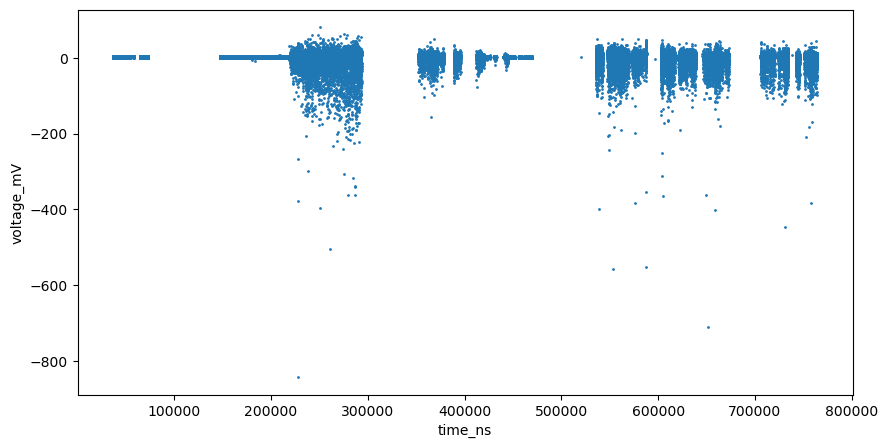

In [15]:
pdf.groupby(pdf.index // 40).agg({'time_ns': 'mean', 'voltage_mV': 'mean'}).plot(x='time_ns', y='voltage_mV', kind='scatter', figsize=(10, 5), s=1)

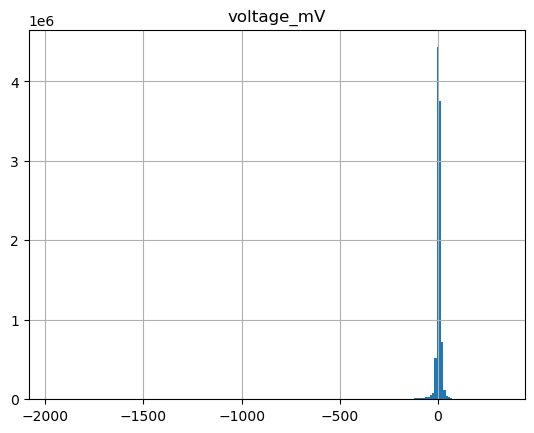

In [16]:
pdf.hist('voltage_mV', bins=200);

### Scaling to Multi-File Processing: 

**Distributed Multi-File Analysis**:

This example demonstrates Dask's **primary advantage**: efficient processing of **multiple files simultaneously**:

**Scaling Strategy**:
```python
filters=[
    ("dataset", "==", "64nA"),     # Same experimental condition
    ("channel_no", "==", 0),       # Same measurement channel  
    ("trc_file_no", "<", 10),      # Multiple trace files (0-9)
    # ("segment_no", "<", 30),     # Potentially multiple segments
]
```

In [ ]:
ddf = dd.read_parquet(
    lv1_path,
    filters=[
        ("dataset", "==", "64nA"),
        ("channel_no", "==", 0),
        ("trc_file_no", "<", 10),
        #("segment_no", "<", 30),
    ],
)

In [ ]:
ddf.head()

In [ ]:
ddf.voltage_mV.mean().compute()

In [ ]:
ddf.voltage_mV.count().compute()

### Advanced Distributed Histogram Analysis

**Two-Stage Distributed Histogram Strategy**:

**Stage 1: Range Determination**
```python
xmin = ddf.voltage_mV.min().compute()
xmax = ddf.voltage_mV.max().compute()
```

**Why Range Pre-computation is Essential**:
- **Consistent binning**: All workers must use identical bin boundaries for meaningful results
- **Optimal resolution**: Tight bounds minimize empty bins and maximize histogram resolution
- **Parallel efficiency**: Each worker computes local min/max, then results are combined
- **Memory optimization**: Avoids loading entire dataset just for range determination

**Stage 2: Distributed Histogram Construction**
```python
hist_dask, edges_dask = da.histogram(ddf.voltage_mV, bins=200, range=(xmin, xmax))
```

**Distributed Algorithm Breakdown**:
1. **Local histograms**: Each worker computes histogram for its data partitions
2. **Identical binning**: All workers use same range and bin count for consistency
3. **Result aggregation**: Local histogram counts summed across all partitions
4. **Memory efficiency**: Only histogram results (not raw data) transferred between workers

**Scientific Computing Applications**:
- **Instrument calibration**: Voltage distribution analysis for detector characterization
- **Quality control**: Distribution changes indicate measurement system drift
- **Signal detection**: Identify unusual distributions suggesting signal presence
- **Comparative studies**: Compare distributions across different experimental conditions

In [ ]:
xmin = ddf.voltage_mV.min().compute()
xmax = ddf.voltage_mV.max().compute()
hist_dask, edges_dask = da.histogram(ddf.voltage_mV, bins=200, range=(xmin, xmax))

In [ ]:
hist_dask_comp = hist_dask.compute()

In [ ]:
plt.plot(edges_dask[:-1], hist_dask_comp, drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('voltage [mV]')
plt.ylabel('counts')
plt.grid()

### Full Dataset Processing: Distributed Analysis at Scale

**Loading Entire Dataset Collections**:

```python
ddf = dd.read_parquet(lv2_path)
```

This operation creates a **lazy distributed DataFrame** spanning the **entire dataset collection**:

**Massive Scale Advantages**:
- **No memory constraints**: Dataset size can exceed available RAM by orders of magnitude
- **Automatic partitioning**: Dask automatically divides work across available resources
- **Lazy evaluation**: No data loaded until analysis actually requested
- **Interactive exploration**: Rapid queries against massive datasets

**Scientific Research Benefits**:
- **Complete experimental coverage**: Analysis across all available experimental data
- **Statistical power**: Maximum sample sizes for robust statistical analysis
- **Systematic studies**: Compare results across all experimental conditions and time periods
- **Discovery potential**: Identify rare events or subtle effects requiring large sample sizes

**Performance Characteristics**:
- **Metadata operations**: Dataset information (columns, structure) available immediately
- **Query optimization**: Complex filters optimized before execution
- **Parallel execution**: All subsequent operations automatically distributed
- **Memory management**: Only working datasets loaded into memory during computation

**When This Approach is Essential**:
- **Exploratory data analysis**: Need to understand overall dataset characteristics
- **Comprehensive studies**: Analysis requiring access to all available experimental data
- **Rare event searches**: Looking for infrequent phenomena requiring large sample sizes
- **Systematic effect studies**: Comparing results across extensive parameter ranges

This demonstrates the **ultimate scaling advantage** of distributed computing for scientific analysis.

In [8]:
ddf = dd.read_parquet(lv2_path)

In [9]:
ddf.head()

,index,trc_file_no,segment_no,delta_t_sec,peak_rise_time_ns,peak_falling_time_ns,peak_cfd_ns,peak_area_mV_ns,peak_length_ns,peak_amplitude_mV,optimum_period_ns,mean_phase_shift_ns,spread_phase_shift_ns,micropulse_no,t_mid_ns,peak_offset_ns,sign,dataset,channel_no
0,0,0,0,0.0,0.386436,0.189930,827.425406,1.751539,0.148071,9.463067,38.081231,1.551495,0.537438,22.0,839.338587,-11.913181,negative,0p5nA,0
1,1,0,0,0.0,0.062531,0.440093,2645.148181,1.742134,0.124026,9.180918,38.081231,1.551495,0.537438,69.0,2629.156465,15.991716,negative,0p5nA,0
2,2,0,0,0.0,0.140212,0.061022,6722.365419,1.792294,0.142631,9.086869,38.081231,1.551495,0.537438,176.0,6703.848230,18.517189,negative,0p5nA,0
3,3,0,0,0.0,0.687940,0.070371,9100.102696,1.588519,0.104543,8.052322,38.081231,1.551495,0.537438,239.0,9102.965811,-2.863115,negative,0p5nA,0
4,4,0,0,0.0,0.128568,0.208718,22483.889270,1.651219,0.116299,8.679320,38.081231,1.551495,0.537438,590.0,22469.478049,14.411221,negative,0p5nA,0


### Complex Multi-Condition Query Processing

**Advanced Scientific Data Selection**:

```python
ddf.query('dataset=="0p5nA" and channel_no==0 and peak_length_ns > 0.4 and sign=="negative"')
```

This demonstrates **sophisticated distributed query optimization**:

**Multi-Condition Filter Strategy**:
1. **Experimental condition**: `dataset=="0p5nA"` - specific current measurement setting
2. **Channel selection**: `channel_no==0` - focus on specific detector channel  
3. **Quality filter**: `peak_length_ns > 0.4` - ensure significant signal events
4. **Physics constraint**: `sign=="negative"` - select specific signal polarity

**Distributed Query Optimization**:
- **Predicate pushdown**: Filters applied at file reading stage, not after loading
- **Parallel evaluation**: Each worker applies filters to its data partitions independently  
- **Early termination**: Partitions not matching filters are skipped entirely
- **Memory efficiency**: Only matching data loaded into worker memory

**Scientific Analysis Benefits**:
- **Focused analysis**: Select specific experimental conditions for detailed study
- **Quality control**: Combine experimental and quality filters for robust analysis
- **Physics insights**: Filter on physics-relevant parameters (polarity, amplitude, timing)
- **Interactive exploration**: Rapidly explore different filter combinations across large datasets

**Performance Characteristics**:
- **Linear scaling**: Query performance scales with dataset size and available workers
- **Filter selectivity**: More selective filters provide better performance benefits
- **Network optimization**: Only matching data transferred between storage and compute nodes
- **Memory management**: Filtered results fit more easily in available memory

In [ ]:
# ddf.query('dataset=="0p5nA" and peak_length_ns > 0.4').peak_amplitude_mV.hist(bins=200, range=(0, 2)).compute();

In [10]:
hist_dask, edges_dask = da.histogram(ddf.query('dataset=="0p5nA" and channel_no==0 and peak_length_ns > 0.4 and sign=="negative"').peak_amplitude_mV, bins=200, range=(0, 200))

In [11]:
hist_dask_comp = hist_dask.compute()

2025-09-24 23:06:11,124 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.61 GiB -- Worker memory limit: 7.81 GiB
2025-09-24 23:06:11,524 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.57 GiB -- Worker memory limit: 7.81 GiB
2025-09-24 23:06:12,494 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 6.61 GiB -- Worker memory limit: 7.81 GiB
2025-09-24 23:06:12,789 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

KilledWorker: Attempted to run task ('getitem-histogram-sum-query-read_parquet-sum-1ef556eb4e6425ff7f4e520f17e0a076', 12, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:41703. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [ ]:
plt.plot(edges_dask[:-1], hist_dask_comp, drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('voltage [mV]')
plt.ylabel('counts')
plt.grid()